In [21]:
%config Completer.use_jedi = False  # enable code auto-completion

import numpy as np    # library for numerical computations (vectors, matrices, tensors)
import pandas as pd    # library for data manipulation and analysis
import matplotlib.pyplot as plt    # library providing tools for plotting data
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.metrics import mean_squared_error    # function to calculate mean squared error 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
#import all the usefull packages
from pyproj import CRS
import os
from geopandas.tools import geocode

import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA


In [85]:
data = pd.read_csv('orders_autumn_2020.csv')


data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

data['dayOfWeek'] = data['TIMESTAMP'].dt.day_name()
data['date'] =''
for i in range(0,len(data['dayOfWeek'])-1):
    if data.at[i,'dayOfWeek']  == 'Saturday' or data.at[i,'dayOfWeek'] == 'Sunday':
        data.at[i,'date']='Weekend'
    else:
        data.at[i, 'date'] = 'weekday'
data = data[['TIMESTAMP',  'ESTIMATED_DELIVERY_MINUTES' ,'ACTUAL_DELIVERY_MINUTES', 'dayOfWeek', 'date' ]]
data['dummy'] = 0
for i in range(0,len(data['dayOfWeek'])-1):
    if data.at[i,'dayOfWeek']  == 'Saturday' or data.at[i,'dayOfWeek'] == 'Sunday':
        data.at[i,'dummy']='1'
    else:
        data.at[i, 'dummy'] = '0'
#dummies = pd.get_dummies(data, columns=['date'])

data.set_index(pd.DatetimeIndex(data['TIMESTAMP']), inplace=True)

data = data.between_time('10:00','13:00')

data = data[data['ACTUAL_DELIVERY_MINUTES'] <= 40]
data = data[data['ACTUAL_DELIVERY_MINUTES'] >= 30]

print(len(data))

1412


In [86]:
X = data[['ESTIMATED_DELIVERY_MINUTES', 'dummy']].to_numpy().reshape(-1, 2)
y = data['ACTUAL_DELIVERY_MINUTES'].to_numpy()

In [87]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test =train_test_split(X_rem, y_rem, test_size=0.33, random_state=42)

In [88]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [89]:
degrees = [1,2, 3,4, 5,6,7,8,9, 10]    

# we will use this variable to store the resulting training errors for each polynomial degree
tr_errors = []          
val_errors = []

plt.figure(figsize=(8, 20))    # create a new figure with size 8*20
for i, degree in enumerate(degrees):    # use for-loop to fit polynomial regression models with different degrees    
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly 
    poly = PolynomialFeatures(degree=degree)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit and transform the raw features
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train, y_pred_train)   
    print(f' traing error: {tr_error}')
    X_val_poly =  poly.transform(X_val)   
    y_pred_val = lin_regr.predict(X_val_poly)   
    val_error = mean_squared_error(y_val, y_pred_val)
    print(f' validation error: {val_error}')
   
    tr_errors.append(tr_error)
    val_errors.append(val_error)
    

 traing error: 9.597084180357912
 validation error: 9.522601641703481
 traing error: 9.587869832067762
 validation error: 9.581785955890116
 traing error: 9.560645283376207
 validation error: 9.663831338065721
 traing error: 9.560471406572244
 validation error: 9.659331197597755
 traing error: 9.533024016468081
 validation error: 9.686095209439587
 traing error: 9.486893704174427
 validation error: 9.952438977661906
 traing error: 9.438098861937354
 validation error: 11.296705637533604
 traing error: 9.520445065141974
 validation error: 9.659117974911263
 traing error: 9.53464642649845
 validation error: 9.707942827324128
 traing error: 9.566293074357683
 validation error: 9.883489608578392


<Figure size 576x1440 with 0 Axes>

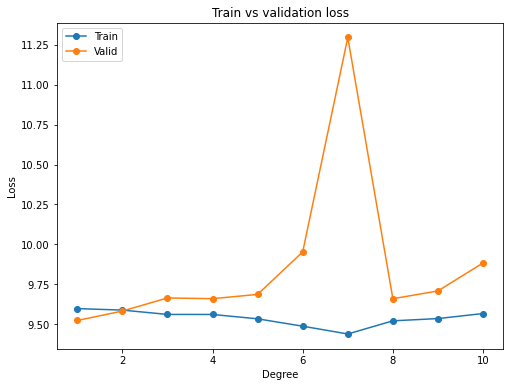

<Figure size 432x288 with 0 Axes>

In [90]:
plt.figure(figsize=(8, 6))

plt.plot(degrees, tr_errors, label = 'Train', marker='o')
plt.plot(degrees, val_errors,label = 'Valid',marker='o')
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()
plt.savefig('figure_1.pdf', dpi=300)

In [91]:
data

,TIMESTAMP,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,dayOfWeek,date,dummy
TIMESTAMP,,,,,,
2020-08-01 10:09:00,2020-08-01 10:09:00,28,36,Saturday,Weekend,1
2020-08-01 10:18:00,2020-08-01 10:18:00,34,39,Saturday,Weekend,1
2020-08-01 10:36:00,2020-08-01 10:36:00,32,30,Saturday,Weekend,1
2020-08-01 10:55:00,2020-08-01 10:55:00,36,30,Saturday,Weekend,1
2020-08-01 10:57:00,2020-08-01 10:57:00,34,30,Saturday,Weekend,1
...,...,...,...,...,...,...
2020-09-30 11:40:00,2020-09-30 11:40:00,37,40,Wednesday,weekday,0
2020-09-30 11:48:00,2020-09-30 11:48:00,25,31,Wednesday,weekday,0
2020-09-30 12:02:00,2020-09-30 12:02:00,29,30,Wednesday,weekday,0


In [92]:

from sklearn.linear_model import Ridge

In [101]:
degrees = [1,2, 3,4, 5,6,7,8,9, 10]    

# we will use this variable to store the resulting training errors for each polynomial degree
tr_errors = []          
val_errors = []

plt.figure(figsize=(8, 20))    # create a new figure with size 8*20
for i, degree in enumerate(degrees):    # use for-loop to fit polynomial regression models with different degrees    
    lin_regr = Ridge(alpha=1, normalize=True) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly 
    poly = PolynomialFeatures(degree=degree)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit and transform the raw features
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train, y_pred_train)   
    print(f' traing error: {tr_error}')
    X_val_poly =  poly.transform(X_val)   
    y_pred_val = lin_regr.predict(X_val_poly)   
    val_error = mean_squared_error(y_val, y_pred_val)
    print(f' validation error: {val_error}')
   
    tr_errors.append(tr_error)
    val_errors.append(val_error)

 traing error: 9.69207938793763
 validation error: 9.494958619652028
 traing error: 9.641809279369108
 validation error: 9.479815132311469
 traing error: 9.62699876451402
 validation error: 9.483956707198587
 traing error: 9.622925281375966
 validation error: 9.494752130629665
 traing error: 9.62329718956532
 validation error: 9.505715864155476
 traing error: 9.624721806237586
 validation error: 9.512950748274918
 traing error: 9.625437775224963
 validation error: 9.516466892254378
 traing error: 9.625255067897559
 validation error: 9.518193374478136
 traing error: 9.624637780379615
 validation error: 9.519727173808503
 traing error: 9.62397476261718
 validation error: 9.521690259159731


<Figure size 576x1440 with 0 Axes>

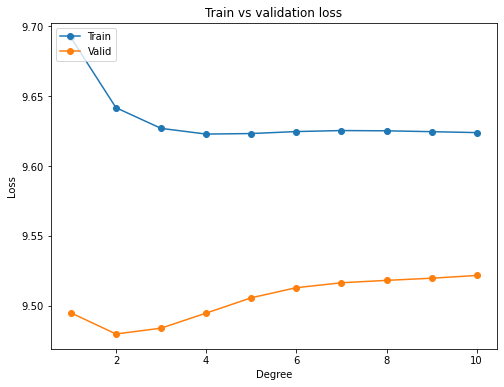

In [102]:
plt.figure(figsize=(8, 6))

plt.plot(degrees, tr_errors, label = 'Train', marker='o')
plt.plot(degrees, val_errors,label = 'Valid',marker='o')
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()